In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../Code/')
from testWN import testWN as twm
from surrogate_model_training_data import get_data

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
from surrogate_model_training_data import get_data

# Get network informations

In [4]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Data Pre-Processing

Get clusters:

In [5]:
cluster_label_path = '../clustering/'
cluster_labels = pd.read_json(cluster_label_path+'cluster_labels_dt1h_both_datasets.json')
pressure_factor = pd.read_json(cluster_label_path+'pressure_factor_dt1h_both_datasets.json')
n_clusters = 30

# Create Training Data:

## with random control input:

In [6]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]
n_arx = 0
nn_input_rc, nn_output_rc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False)
nn_input_rc.shape

(100800, 46)

Apply filters:

In [54]:
def filter_io(nn_input, nn_output):
    f_1 = (nn_output[('aux_outputs','pump_energy')]<=-10).any(axis=1)
    f_2 = (nn_output[('aux_outputs','jun_cl_press_mean')]<=0).any(axis=1)

    # Maximum junction pressure should not exceed .. :
    jun_cl_press_fac_max = pressure_factor.groupby(cluster_labels.loc['pressure_cluster'], axis=1).max()
    f_3 = ((nn_output[('aux_outputs','jun_cl_press_mean')]*jun_cl_press_fac_max.to_numpy())>=400).any(axis=1)

    # Tank level should not become smaller than 0.2 at next timestep:
    f_4 = ((nn_input[('sys_states','tank_press')]+nn_output[('sys_states','tank_press')])<0.5).any(axis=1)
    
    # Tank level should not be at the maximum
    max_tank_level = np.array([6.75, 6.5, 5, 5.5, 4.5, 5.9, 4.7]).reshape(1,-1)
    #f_5 = ((nn_input[('sys_states','tank_press')]+nn_output[('sys_states','tank_press')])>max_tank_level-0.01).any(axis=1)
    
    f = ~f_1&~f_2&~f_3&~f_4#&~f_5
    return f

In [55]:
f = filter_io(nn_input_rc, nn_output_rc)
nn_input_rc_filtered = nn_input_rc.loc[f]
nn_output_rc_filtered = nn_output_rc.loc[f]
nn_input_rc_filtered.shape

(9561, 46)

## without random control input:

In [56]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_nc, nn_output_nc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False)
nn_input_nc.shape

(100800, 46)

In [57]:
f = filter_io(nn_input_nc, nn_output_nc)
nn_input_nc_filtered = nn_input_nc.loc[f]
nn_output_nc_filtered = nn_output_nc.loc[f]
nn_input_nc_filtered.shape

(11148, 46)

In [59]:
n_data_nc = nn_input_nc_filtered.shape[0]//2
nn_input_nc_sampled = nn_input_nc_filtered.head(n_data_nc)
nn_output_nc_sampled = nn_output_nc_filtered.head(n_data_nc)
nn_input_nc_sampled.shape

(5574, 46)

## From previous MPC solutions

In [60]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/001_economic/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_mpc, nn_output_mpc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False)
nn_input_mpc.shape

(1438, 46)

In [61]:
f = filter_io(nn_input_mpc, nn_output_mpc)
nn_input_mpc_filtered = nn_input_mpc.loc[f]
nn_output_mpc_filtered = nn_output_mpc.loc[f]

nn_input_mpc_filtered.shape

(439, 46)

In [62]:
n_aug_mpc = 10
nn_input_mpc_augmented = pd.concat(n_aug_mpc*[nn_input_mpc_filtered])
nn_output_mpc_augmented = pd.concat(n_aug_mpc*[nn_output_mpc_filtered])
nn_input_mpc_augmented.shape

(4390, 46)

## Concatenate everything:

In [63]:
nn_input =  pd.concat((nn_input_rc_filtered,  nn_input_nc_sampled,  nn_input_mpc_augmented), axis=0)
nn_output = pd.concat((nn_output_rc_filtered, nn_output_nc_sampled, nn_output_mpc_augmented), axis=0)

## Manually extend data to balance histogramms on input space

In [70]:
cond = nn_input[('sys_states','tank_press','T6')]<4.9
nn_input = pd.concat((nn_input, nn_input.loc[cond]))
nn_output = pd.concat((nn_output, nn_output.loc[cond]))

In [71]:
nn_input.shape

(39650, 46)

<IPython.core.display.Javascript object>


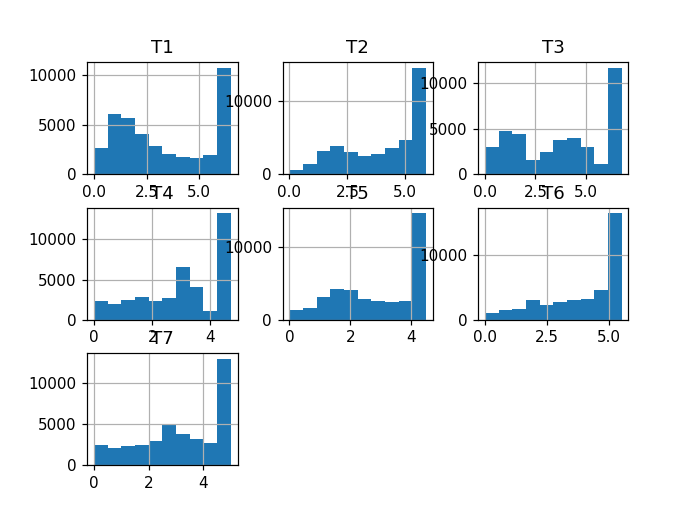

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9723efa410>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f9723e975d0>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f9723eb8890>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7f9723e55bd0>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f9723e76ed0>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f9723e1cc90>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7f9723e3c510>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f9723ddb810>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f9723de22d0>]], dtype=object)

In [72]:
nn_input[('sys_states','tank_press')].hist()
#nn_input[('sys_inputs','head_pump_speed')].hist()
#nn_input[('sys_inputs','PRValve_dp')].hist()
#nn_input[('sys_inputs','TCValve_throttle')].hist()
#nn_input[('sys_inputs','jun_cl_demand_sum')].hist()


### Normalize Data:

In [73]:
input_offset = 0*nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = 0*nn_output.mean()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

### Train / Test Splitting

In [74]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2)

In [75]:
X_train.shape

(31720, 46)

# Neural Network

## Create Model

In [76]:
n_layer = 5
n_units = 50
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nn_input.shape[1]
model_param['n_out'] = nn_output.shape[1]
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 46)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2350      
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_8 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_9 (Dense)              (None, 42)                2142      
Total params: 12,142
Trainable params: 12,142
Non-trainable params: 0
_______________________________________________________

## Train model

In [77]:
optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-8, patience=50, mode='min')
model.compile(optimizer=optim,
              loss='mse')

In [80]:
history = model.fit(X_train.to_numpy(), 
                    Y_train.to_numpy(), 
                    batch_size=5000, 
                    epochs=1000,
                    validation_data=(X_test.to_numpy(),Y_test.to_numpy()),
                    callbacks=[callback])

Train on 31720 samples, validate on 7930 samples
Epoch 1/1000
31720/31720 [==============================] - 0s 8us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 2/1000
31720/31720 [==============================] - 0s 10us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 3/1000
31720/31720 [==============================] - 0s 9us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 4/1000
31720/31720 [==============================] - 0s 10us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 5/1000
31720/31720 [==============================] - 0s 7us/sample - loss: 0.0013 - val_loss: 0.0012
Epoch 6/1000
31720/31720 [==============================] - 0s 6us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 7/1000
31720/31720 [==============================] - 0s 9us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 8/1000
31720/31720 [==============================] - 0s 10us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 9/1000
31720/31720 [==============================] - 0s 8us/sample - loss: 0.

31720/31720 [==============================] - 0s 7us/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 76/1000
31720/31720 [==============================] - 0s 6us/sample - loss: 0.0014 - val_loss: 0.0014
Epoch 77/1000
31720/31720 [==============================] - 0s 6us/sample - loss: 0.0014 - val_loss: 0.0012
Epoch 78/1000
31720/31720 [==============================] - 0s 6us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 79/1000
31720/31720 [==============================] - 0s 7us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 80/1000
31720/31720 [==============================] - 0s 6us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 81/1000
31720/31720 [==============================] - 0s 6us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 82/1000
31720/31720 [==============================] - 0s 6us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 83/1000
31720/31720 [==============================] - 0s 7us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 84/1000
31720/31720 [======

31720/31720 [==============================] - 0s 7us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 150/1000
31720/31720 [==============================] - 0s 5us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 151/1000
31720/31720 [==============================] - 0s 5us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 152/1000
31720/31720 [==============================] - 0s 6us/sample - loss: 0.0013 - val_loss: 0.0014
Epoch 153/1000
31720/31720 [==============================] - 0s 7us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 154/1000
31720/31720 [==============================] - 0s 8us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 155/1000
31720/31720 [==============================] - 0s 6us/sample - loss: 0.0012 - val_loss: 0.0013
Epoch 156/1000
31720/31720 [==============================] - 0s 6us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 157/1000
31720/31720 [==============================] - 0s 7us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 158/1000
31720/3172

31720/31720 [==============================] - 0s 7us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 224/1000
31720/31720 [==============================] - 0s 6us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 225/1000
31720/31720 [==============================] - 0s 8us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 226/1000
31720/31720 [==============================] - 0s 8us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 227/1000
31720/31720 [==============================] - 0s 7us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 228/1000
31720/31720 [==============================] - 0s 6us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 229/1000
31720/31720 [==============================] - 0s 6us/sample - loss: 0.0011 - val_loss: 0.0012
Epoch 230/1000
31720/31720 [==============================] - 0s 6us/sample - loss: 0.0012 - val_loss: 0.0014
Epoch 231/1000
31720/31720 [==============================] - 0s 6us/sample - loss: 0.0012 - val_loss: 0.0012
Epoch 232/1000
31720/3172

Save model:

In [95]:
model_path = './models/'
model_name = '007_man_5x50_both_datasets_filtered_mpc02'
model.save(model_path+model_name+'.h5')

train_data_param={
    'input_offset': input_offset,
    'input_scaling': input_scaling,
    'output_offset': output_offset,
    'output_scaling': output_scaling
}

with open(model_path+model_name+'_train_data_param.pkl','wb') as f:
    pickle.dump(train_data_param, f)

# Validation

In [82]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/Validation/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_val_list, nn_output_val_list = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, return_lists=True)

In [83]:
class simulator:
    def __init__(self, model, input_scaling, output_scaling, input_offset, output_offset, x0, t0):
        self.model = model
        
        self.input_scaling = input_scaling.to_numpy().reshape(1,-1)
        self.output_scaling = output_scaling.to_numpy().reshape(1,-1)
        self.input_offset = input_offset.to_numpy().reshape(1,-1)
        self.output_offset = output_offset.to_numpy().reshape(1,-1)
        
        self.x = x0
        self.n_x = x0.shape[1]
        self.aux = []
                
        self.t = np.array([t0]).reshape(-1,1)
        self.dt = 3600
            
    def eval_nn(self):
        # Scale input:
        self.nn_in = np.concatenate((self.x[[-1],:], self.u[[-1],:]),axis=1).reshape(1,-1)
        self.nn_in_scaled = (self.nn_in-self.input_offset)/self.input_scaling
        # Evaluate NN:
        self.nn_out_scaled = self.model.predict(self.nn_in_scaled)
        # Scale output:
        self.nn_out = self.nn_out_scaled*self.output_scaling+self.output_offset
#         x_new = self.nn_out[:,:self.n_x]
        x_new = self.x[[-1],:]+self.nn_out[:,:self.n_x]
        aux_new = self.nn_out[:,self.n_x:]
        self.aux.append(aux_new)
    
        self.x = np.append(self.x, x_new, axis=0)
        self.t = np.append(self.t, np.copy(self.t)[[-1]]+self.dt, axis=0)
        
        
    def next_step(self, sys_inputs_now):
        if 'u' in self.__dict__:
            self.u = np.append(self.u, sys_inputs_now.reshape(1,-1), axis=0)
        else:
            self.u = sys_inputs_now.reshape(1,-1)
        
        self.eval_nn()

In [84]:
val_i = 0

sys_states = nn_input_val_list[val_i]['sys_states']
sys_inputs = nn_input_val_list[val_i]['sys_inputs']
sys_aux_outputs = nn_output_val_list[val_i]['aux_outputs']

x0 = sys_states.head(1).to_numpy()
t0 = 0

nsim = simulator(model, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [85]:
for k in range(10):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t.flatten())
sim_aux = pd.DataFrame(np.concatenate(nsim.aux), columns = sys_aux_outputs.columns,index=nsim.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


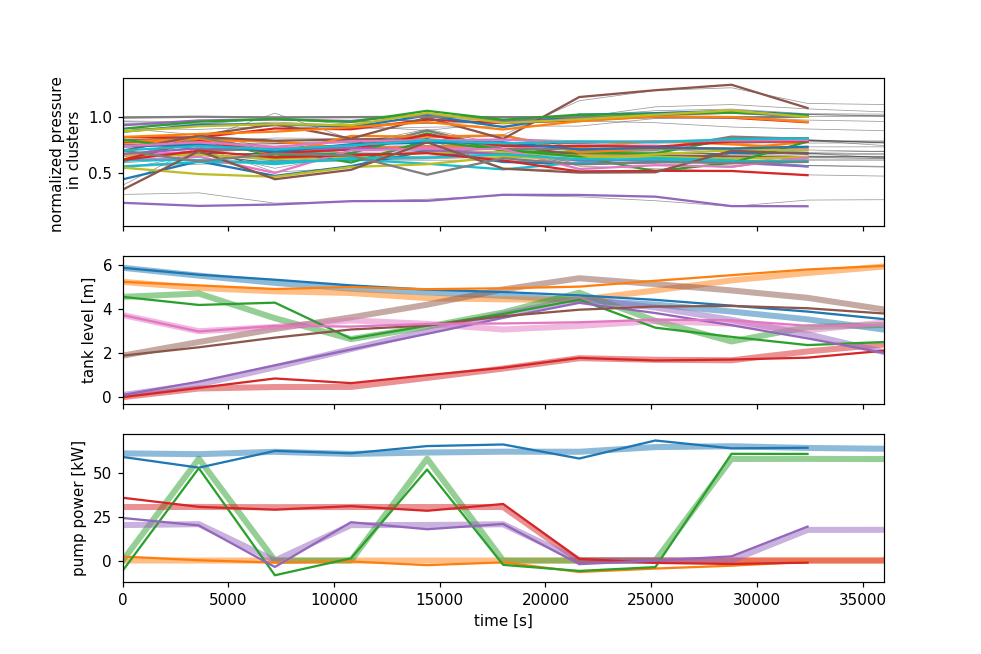

Text(0.5, 0, 'time [s]')

In [86]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,6))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')

# Linear Model

In [87]:
linear_reg = LinearRegression().fit(nn_input_scaled.to_numpy(), nn_output_scaled.to_numpy())

In [92]:
x0 = sys_states.head(1).to_numpy()
t0 = sys_states.head(1).index.to_numpy()

nsim_lin = simulator(linear_reg, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [93]:
for k in range(10):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim_lin.next_step(sys_inputs_now)
sim_res_lin = pd.DataFrame(nsim_lin.x, columns=sys_states.columns, index=nsim_lin.t.flatten())
sim_aux_lin = pd.DataFrame(np.concatenate(nsim_lin.aux), columns = sys_aux_outputs.columns,index=nsim_lin.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


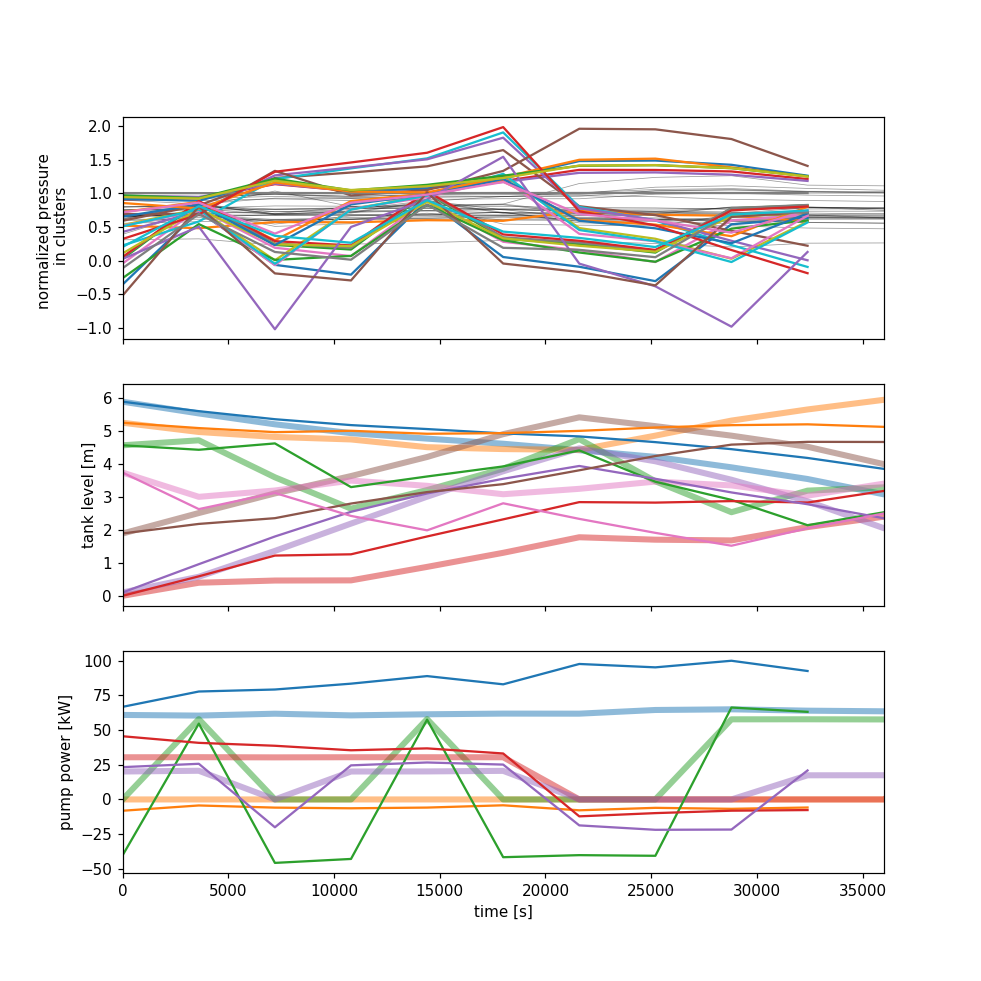

Text(0.5, 0, 'time [s]')

In [94]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,9))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux_lin['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res_lin['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux_lin['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res_lin.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')